In [1]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler 

In [2]:
CROPPED_PATH =  'cp'

## image vectors 

In [3]:
def calculate_and_standardize_histograms(path):
    breeds= []
    histograms = []
    for i,name in enumerate(os.listdir(path)):
        p = os.path.join(path, name)
        files = os.listdir(p)
        images = [file for file in files if file.lower().endswith(('.jpg'))]
        for image in images:
            image_path = os.path.join(p, image)
            img = cv2.imread(image_path)
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hist = cv2.calcHist([gray_image], [0], None, [256], [0,256])
            scale=StandardScaler()
            hist=scale.fit_transform(hist)            
            histograms.append(hist.flatten())
            breeds.append(i)
    return histograms,breeds

In [5]:
histograms,breeds=calculate_and_standardize_histograms(CROPPED_PATH)

In [6]:
histograms = np.array(histograms)
breeds  = np.array(breeds)

In [7]:
histograms.shape

(768, 256)

In [8]:
breeds.shape

(768,)

## train and test split 

In [9]:
from sklearn.model_selection import train_test_split
hist_train,hist_test,breed_train,breed_test=train_test_split(histograms,breeds,test_size=0.2,stratify=breeds)

In [10]:
n_neigbours=[1,3,5,7,10,20]

## Knearestclassifer with standard 5 cross validation 

In [11]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt

In [12]:
#https://scikit-learn.org/stable/modules/cross_validation.html
standard_train_error,standard_val_error=[],[]
standard = KFold(n_splits=5, shuffle=True, random_state=42)
for n in n_neigbours:
    clf = KNeighborsClassifier(n_neighbors=n)    
    t,v=[],[]
    for train_index, val_index in standard.split(hist_train):
        x_train, x_val = hist_train[train_index], hist_train[val_index]
        Y_train, Y_val = breed_train[train_index], breed_train[val_index]
        clf.fit(x_train, Y_train)
        t.append(1- accuracy_score(Y_train, clf.predict(x_train)))
        v.append(1-accuracy_score(Y_val, clf.predict(x_val)))
    standard_train_error.append(np.mean(t))
    standard_val_error.append(np.mean(v))

## KNearestClassifier with stratified 5 fold cross validation

In [16]:
stratified_train_error,stratified_val_error=[],[]
stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n in n_neigbours:
    clf = KNeighborsClassifier(n_neighbors=n)    
    t,v=[],[]
    for train_index, val_index in stratified.split(hist_train,breed_train):
        x_train, x_val = hist_train[train_index], hist_train[val_index]
        Y_train, Y_val = breed_train[train_index], breed_train[val_index]
        clf.fit(x_train, Y_train)
        t.append(1- accuracy_score(Y_train, clf.predict(x_train)))
        v.append(1-accuracy_score(Y_val, clf.predict(x_val)))
    stratified_train_error.append(np.mean(t))
    stratified_val_error.append(np.mean(v))

## graph of error curves

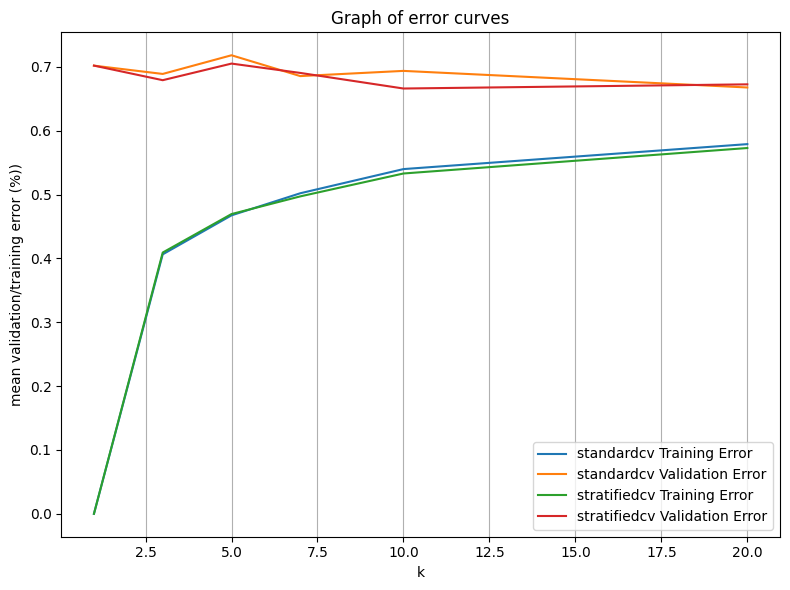

In [20]:
#https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/#
plt.figure(figsize=(8, 6))
plt.plot(n_neigbours, standard_train_error, label="standardcv Training Error")
plt.plot(n_neigbours, standard_val_error, label="standardcv Validation Error")
plt.plot(n_neigbours,stratified_train_error,label="stratifiedcv Training Error")
plt.plot(n_neigbours,stratified_val_error,label="stratifiedcv Validation Error")
plt.xlabel("k")
plt.ylabel("mean validation/training error (%))")
plt.legend()
plt.title("Graph of error curves")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

    Least mean error for  standard training error curve is at k=1
    Least mean error for standard validation error curve is at k=20
    Least mean error for stratififed training error curve is at k=1
    Least mean error for stratified validation error curve is at k= 10

    High complexity occurs at k=1 since models tries to occomodate total data into 1 neighbour
    low complexity occurs at k=20 as models has more neighbours

    model overfits at k=1
    model underfits at k =20

## Performance comparision on assigned models      

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns



import warnings
warnings.filterwarnings("ignore")

#### Neural Network

Mean validation accuray :0.3124607418725066
test accuracy :0.33116883116883117
f1_score :0.3484548240784858


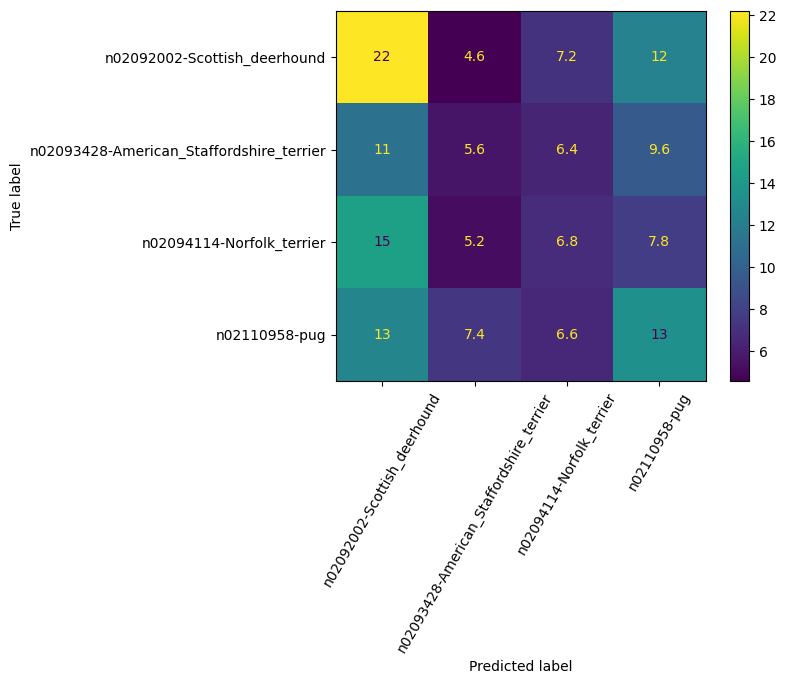

In [46]:
neural_network=MLPClassifier(hidden_layer_sizes=(10,10,10))

tl = []
pl  = []
mean_validation_accuracy = []
val_confusion_matrix = []

for train_index, val_index in stratified.split(histograms,breeds):
    x_train, x_val = histograms[train_index], histograms[val_index]
    y_train, y_val = breeds[train_index], breeds[val_index]

    neural_network.fit(x_train, y_train)
    pred = neural_network.predict(x_val)
    tl.extend(y_val)
    pl.extend(pred)    
    mean_validation_accuracy.append(accuracy_score(y_val,pred))
    cm = confusion_matrix(y_val,pred)
    val_confusion_matrix.append(cm)


val_confusion_matrix = sum(val_confusion_matrix)/len(val_confusion_matrix)
ConfusionMatrixDisplay(val_confusion_matrix, display_labels=os.listdir(CROPPED_PATH)).plot(xticks_rotation=60)


neural_network.fit(hist_train,breed_train)
pred = neural_network.predict(hist_test)
acc=accuracy_score(pred,breed_test)
f1=f1_score(pred,breed_test,average='weighted')
print("Mean validation accuray :"+str(np.mean(mean_validation_accuracy)))
print("test accuracy :"+str(acc))
print("f1_score :"+str(f1))



 ##        Support Vector Machine  

Mean validation accuray :0.269493251846193
test accuracy :0.2662337662337662
f1_score :0.26881866127452003


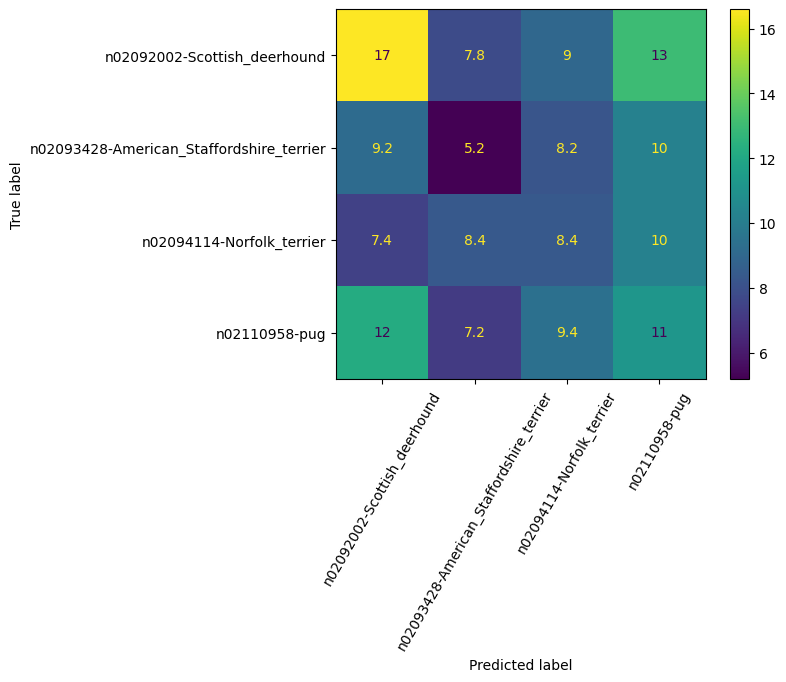

In [47]:
svm=LinearSVC()

tl = []
pl  = []
mean_validation_accuracy = []
val_confusion_matrix = []

for train_index, val_index in stratified.split(histograms,breeds):
    x_train, x_val = histograms[train_index], histograms[val_index]
    y_train, y_val = breeds[train_index], breeds[val_index]

    svm.fit(x_train, y_train)
    pred = svm.predict(x_val)
    tl.extend(y_val)
    pl.extend(pred)    
    mean_validation_accuracy.append(accuracy_score(y_val,pred))
    cm = confusion_matrix(y_val,pred)
    val_confusion_matrix.append(cm)


val_confusion_matrix = sum(val_confusion_matrix)/len(val_confusion_matrix)
ConfusionMatrixDisplay(val_confusion_matrix, display_labels=os.listdir(CROPPED_PATH)).plot(xticks_rotation=60)


svm.fit(hist_train,breed_train)
pred = svm.predict(hist_test)
acc=accuracy_score(pred,breed_test)
f1=f1_score(pred,breed_test,average='weighted')
print("Mean validation accuray :"+str(np.mean(mean_validation_accuracy)))
print("test accuracy :"+str(acc))
print("f1_score :"+str(f1))

 ##  Random Forest

Mean validation accuray :0.3593752652576182
test accuracy :0.33766233766233766
f1_score :0.35774499680118027


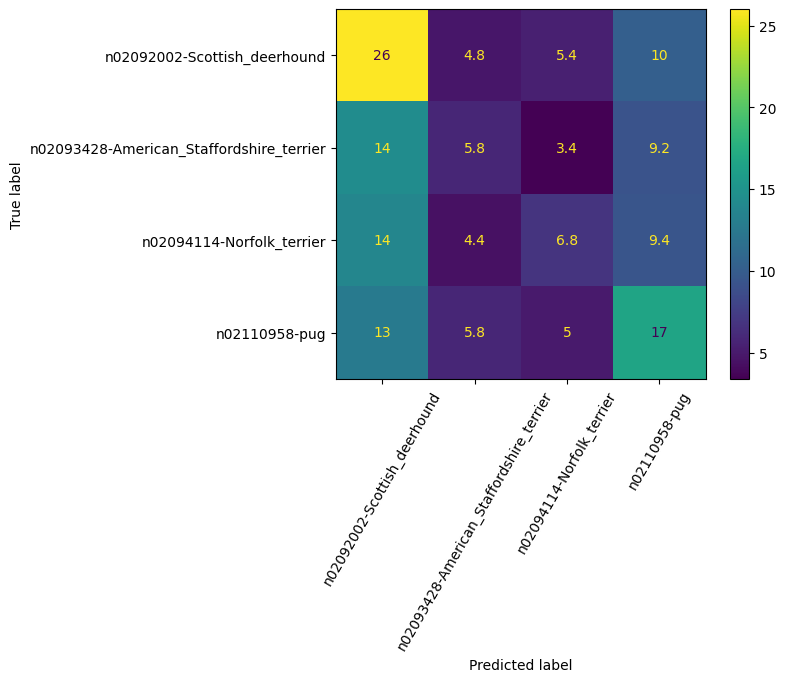

In [48]:
RF=RandomForestClassifier()

tl = []
pl  = []
mean_validation_accuracy = []
val_confusion_matrix = []

for train_index, val_index in stratified.split(histograms,breeds):
    x_train, x_val = histograms[train_index], histograms[val_index]
    y_train, y_val = breeds[train_index], breeds[val_index]

    RF.fit(x_train, y_train)
    pred = RF.predict(x_val)
    tl.extend(y_val)
    pl.extend(pred)    
    mean_validation_accuracy.append(accuracy_score(y_val,pred))
    cm = confusion_matrix(y_val,pred)
    val_confusion_matrix.append(cm)


val_confusion_matrix = sum(val_confusion_matrix)/len(val_confusion_matrix)
ConfusionMatrixDisplay(val_confusion_matrix, display_labels=os.listdir(CROPPED_PATH)).plot(xticks_rotation=60)


RF.fit(hist_train,breed_train)
pred = RF.predict(hist_test)
acc=accuracy_score(pred,breed_test)
f1=f1_score(pred,breed_test,average='weighted')
print("Mean validation accuray :"+str(np.mean(mean_validation_accuracy)))
print("test accuracy :"+str(acc))
print("f1_score :"+str(f1))

Based on Confusion matrices Random forest performs well as it classifies more correct labels than other classifiers.
by observations F1 score,Mean validation accuracy ,test score are high for random forest with 35%,33%,35% respectively
